In [113]:
# data/california_housing_data.py

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

def load_data():
    # Load the dataset
    (x_train_full, y_train_full), _ = tf.keras.datasets.california_housing.load_data()

    # Split the dataset into training and test sets
    x_train, x_test, y_train, y_test = train_test_split(x_train_full, y_train_full, test_size=0.2, random_state=42)

    # Standardize the features (flatten to 2D if necessary)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    # Ensure the standardized values are <= 2 by scaling down
    scaling_factor = 2 / np.max(np.abs(x_train))
    x_train = x_train * scaling_factor
    x_test = x_test * scaling_factor

    # Reshape back to the original shape if required (keeping 2D as per the StandardScaler requirement)
    # No need to reshape to 3D unless your model specifically requires it.

    return (x_train, y_train), (x_test, y_test)


In [114]:
# models/dnn_model.py

import tensorflow as tf
from tensorflow.keras import layers, models

def build_dnn_model(input_shape=(8,)):
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=input_shape),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])

    model.compile(optimizer='adam',
                  loss='mse',  # Mean Squared Error for regression
                  metrics=['mae'])  # Mean Absolute Error for evaluation
    return model


In [115]:
# models/cnn_model.py

import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_model(input_shape=(8,)):
    model = models.Sequential([
        layers.Reshape((input_shape[0], 1), input_shape=input_shape),
        layers.Conv1D(32, 3, activation='relu'),
        layers.MaxPooling1D(2),
        layers.Conv1D(64, 3, activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)  # Output layer for regression
    ])

    model.compile(optimizer='adam',
                  loss='mse',  # Mean Squared Error for regression
                  metrics=['mae'])  # Mean Absolute Error for evaluation
    return model


In [116]:
# train.py

import tensorflow as tf
#from data.california_housing_data import load_data
#from models.dnn_model import build_dnn_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load California Housing data
(x_train, y_train), (x_test, y_test) = load_data()

# Build the DNN model
model = build_dnn_model()

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5)

# Train the model
history = model.fit(x_train, y_train, epochs=100,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Save the trained model
model.save('dnn_california_housing_model_scaled.keras')

# Save the training history
import pickle
with open('history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 56736350208.0000 - mae: 207822.2969 - val_loss: 55135723520.0000 - val_mae: 204903.9688 - learning_rate: 0.0010
Epoch 2/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55077732352.0000 - mae: 204417.9531 - val_loss: 51727331328.0000 - val_mae: 196633.8438 - learning_rate: 0.0010
Epoch 3/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 50025181184.0000 - mae: 192478.0938 - val_loss: 44077137920.0000 - val_mae: 176717.4062 - learning_rate: 0.0010
Epoch 4/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 42832777216.0000 - mae: 172024.9062 - val_loss: 33466374144.0000 - val_mae: 145057.4844 - learning_rate: 0.0010
Epoch 5/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 31523164160.0000 - mae: 138204.4062 - val_loss: 22826149888.0000 - val_mae: 110512.2109 - learning_rate: 0.0010
Epoch 6/100
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 21008898048.0000 - mae: 104144.1094 - val_loss: 15264780288.0000 - val_mae

In [118]:
# evaluate.py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import mse
# from data.california_housing_data import load_data

# Load California Housing data
(x_train, y_train), (x_test, y_test) = load_data()

# Load the trained model
model = keras.models.load_model("dnn_california_housing_model_scaled.keras", custom_objects={'mse': mse})


# Evaluate the model
test_loss, test_mae = model.evaluate(x_test, y_test, verbose=2)
print(f'\nTest MAE: {test_mae}')


104/104 - 1s - 6ms/step - loss: 5093798912.0000 - mae: 51061.5234

Test MAE: 51061.5234375


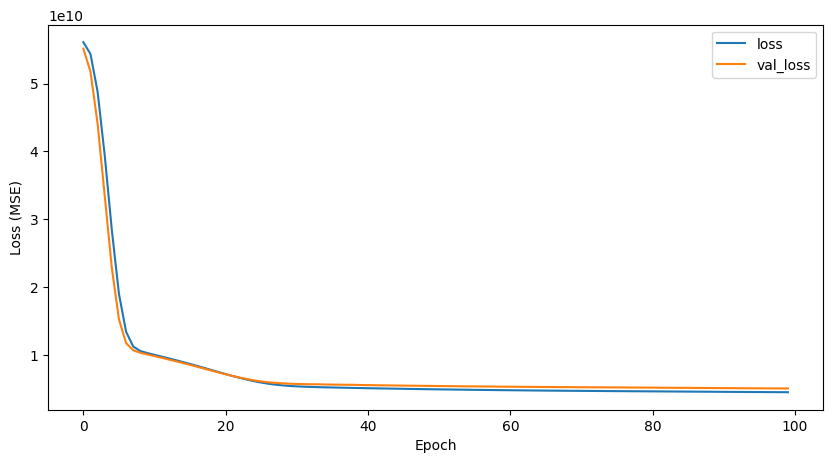

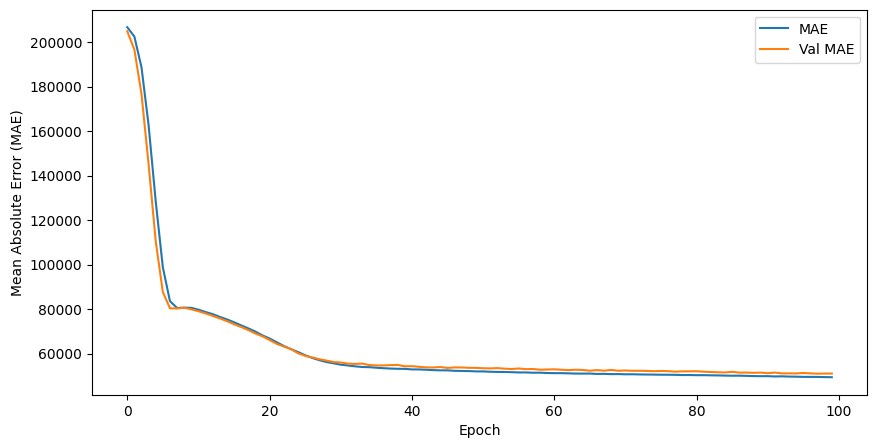

In [119]:
# utils/plot_history.py

import matplotlib.pyplot as plt
import pickle

def plot_history(history_file='history.pkl'):
    with open(history_file, 'rb') as f:
        history = pickle.load(f)

    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend(loc='upper right')
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(history['mae'], label='MAE')
    plt.plot(history['val_mae'], label='Val MAE')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.legend(loc='upper right')
    plt.show()

if __name__ == '__main__':
    plot_history()
